In [1]:
import os, fiona, glob
import geopandas as gpd
import pandas as pd
from rasterio.crs import CRS
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import shapely
import matplotlib.pyplot as plt

In [2]:
# Every time you change something within the code cell, run it once more to update the variable.

BOUNDS = [39.7299, -77.5886, 36.9909, -81.6319] # In decimal coordinate form.  Format: [N, E, S, W].  Select the smallest area possible in your analyses for maximum resoultion!  

API_KEY = '9086887f175d33aa72eda767f5b1e9cd' # Get your API key from opentopography.org.  Students get higher resolution data!

DEM_DATASET = 'USGS30m' # Options are USGS30m, USGS10m, & USGS1m.  Be warned!  As resolution goes up, available download area goes down.

PROJ_TITLE = 'wv_tot' # Create a succinct name with no spaces or leading digits to represent your project file for future exports.

PATH = os.getcwd()

In [3]:
# Import all files from wv GDB.  
dir = f'{PATH}/{PROJ_TITLE}/GeoDatabases'
path_list = glob.glob(f'{dir}/*.zip')
master_dip_gdf = gpd.GeoDataFrame()
master_geol_gdf = gpd.GeoDataFrame()
for path in path_list:
    try:
        layers = fiona.listlayers(path)
        for layer in layers:
            if 'bed' in layer.lower():
                dip_gdf = gpd.read_file(path, layer=layer)
                dip_gdf.columns = [x.lower() for x in dip_gdf.columns]
                master_dip_gdf = pd.concat([master_dip_gdf, dip_gdf], ignore_index=True)
            elif 'cnt_poly' in layer.lower():
                geol_gdf = gpd.read_file(path, layer=layer)
                geol_gdf.columns = [x.lower() for x in geol_gdf.columns]
                master_geol_gdf= pd.concat([master_geol_gdf, geol_gdf], ignore_index=True)
    except Exception as e:
        pass

master_dip_gdf = master_dip_gdf[['dip_angle', 'dip_direct', 'geometry']].drop_duplicates(subset = ['geometry'], keep='first').to_crs(CRS.from_epsg(2283))
master_geol_gdf = master_geol_gdf[['unit_abbrv', 'geometry']].to_crs(CRS.from_epsg(2283))

In [4]:
from pyproj import Proj, transform
import numpy as np

kp_strat_fin = []

ksn_paths = glob.glob(f'{PATH}/{PROJ_TITLE}/lsht_kps/*.csv')
for csv in ksn_paths:
    csv_name = csv.split(sep='/')[-1]
    wshed_name = csv_name[0:-13]
    ksn_df = pd.read_csv(csv, index_col=0)[['x','y','longitude','latitude','wshed','delta_ksn','elevation']]
    kp_df = gpd.GeoDataFrame(data=ksn_df, geometry= gpd.points_from_xy(ksn_df.x, ksn_df.y), crs=CRS.from_epsg(2283))
    kp_dip = gpd.sjoin_nearest(master_dip_gdf, kp_df, max_distance=300, distance_col='dist_from_dip')
    if len(kp_dip) != 0:
        kp_dip = kp_dip.drop(columns=['index_right'])
        kp_strat = gpd.sjoin(left_df=kp_dip, right_df=master_geol_gdf, how='inner')
        kp_strat_fin.append(kp_strat)

In [5]:
for_graphing = []
for df in kp_strat_fin:
    if len(df) > 10:
        for_graphing.append(df)

In [11]:
try:
    os.mkdir(f'{PATH}/{PROJ_TITLE}/radial_plots')
except FileExistsError:
    print('File exists')

for df_to_b_graphed in for_graphing:

    dip_data = df_to_b_graphed.dip_angle # get dip data
    dip_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90] #bin edges
    dip_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'] #labels
    binned_dips = pd.cut(dip_data, bins=dip_bins, labels=dip_labels, right=True) #binned

    # Now the same for elevation
    elev_data = df_to_b_graphed.elevation
    binned_elev = pd.cut(elev_data, bins = np.arange(round(elev_data.min()-10, -1), round(elev_data.max()+30, -1), step=20))

    #add these bins to the df
    df_to_b_graphed['dip_bin'] = binned_dips
    df_to_b_graphed['elev_bin'] = binned_elev
    # Debug
    # display(df_to_b_graphed)

    # Sort our data by the underlying geology.
    data_by_geol = pd.DataFrame(columns = ['Unit', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])
    for x in df_to_b_graphed.unit_abbrv.unique():
        bin_count = df_to_b_graphed[df_to_b_graphed.unit_abbrv == x].groupby('dip_bin').size().values
        new_row = pd.DataFrame([x]+list(bin_count)).T
        new_row.columns = ['Unit', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
        data_by_geol = pd.concat([data_by_geol, new_row])

    # Now by elevation
    data_by_elev = pd.DataFrame(columns = ['elev_bin', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90'])
    for x in sorted(df_to_b_graphed.elev_bin.unique()):
        bin_count = df_to_b_graphed[df_to_b_graphed.elev_bin == x].groupby('dip_bin').size().values
        new_row = pd.DataFrame([x]+list(bin_count)).T
        new_row.columns = ['elev_bin', '0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
        data_by_elev = pd.concat([data_by_elev, new_row])

    # Debug
    # display(data_by_geol, data_by_elev)

    # Graphing
    # By geology

    fig = plt.figure(figsize=(10, 10), dpi=300)

    num_discrete_levels = len(data_by_geol)
    discrete_cmap = plt.cm.get_cmap('plasma', num_discrete_levels)

    ax = fig.add_subplot(111, polar=True)
    ax.set_thetamin(270)
    ax.set_thetamax(360)
    labels = labels = np.flip(['10', '20', '30', '40', '50', '60', '70', '80', '90'])
    perim = -np.pi/2
    width = (2*np.pi/36)
    start_point = (perim-.5*width)
    theta = np.arange(width/2, np.abs(start_point), step = width)
    theta = [number * -1 for number in theta]
    ax.set_xticklabels(labels)
    bottom = 0
    for i in range(0, len(data_by_geol)):
        if i==0:
            ax.bar(theta, data_by_geol.iloc[i][1:].values, width = width, label = data_by_geol.iloc[i][0], color = discrete_cmap.colors[i])
            bottom = data_by_geol.iloc[0][1:].values
        else:
            ax.bar(theta, data_by_geol.iloc[i][1:].values, width = width, bottom = bottom, label = data_by_geol.iloc[i][0], color = discrete_cmap.colors[i])
            bottom += data_by_geol.iloc[i][1:].values

    ax.set_title(f'{str(df_to_b_graphed.wshed.iloc[0]).replace("_"," ")} Knickpoints by Dip Angle and Bedrock Geology')
    ax.set_xlabel('Dip Degrees (°)')
    ax.set_ylabel('Count')

    plt.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5,-.1), title='Unit Abbreviation')
    plt.savefig(f'{PATH}/{PROJ_TITLE}/radial_plots/{df_to_b_graphed.wshed.iloc[0]}_radial_geol.png', bbox_inches = 'tight')
    # plt.show()
    plt.close()


    # By elevation.
    fig = plt.figure(figsize=(10, 10), dpi=300)

    num_discrete_levels = len(data_by_elev)
    discrete_cmap = plt.cm.get_cmap('plasma', num_discrete_levels)

    ax = fig.add_subplot(111, polar=True)
    ax.set_thetamin(270)
    ax.set_thetamax(360)
    labels = labels = np.flip(['10', '20', '30', '40', '50', '60', '70', '80', '90'])
    perim = -np.pi/2
    width = (2*np.pi/36)
    start_point = (perim-.5*width)
    theta = np.arange(width/2, np.abs(start_point), step = width)
    theta = [number * -1 for number in theta]
    ax.set_xticklabels(labels)
    bottom = 0
    for i in range(0, len(data_by_elev)):
        if i==0:
            ax.bar(theta, data_by_elev.iloc[i][1:].values, width = width, label = data_by_elev.iloc[i][0], color = discrete_cmap.colors[i])
            bottom = data_by_elev.iloc[0][1:].values
        else:
            ax.bar(theta, data_by_elev.iloc[i][1:].values, width = width, bottom = bottom, label = data_by_elev.iloc[i][0], color = discrete_cmap.colors[i])
            bottom += data_by_elev.iloc[i][1:].values

    ax.set_title(f'{str(df_to_b_graphed.wshed.iloc[0]).replace("_"," ")} Knickpoints by Dip Angle and elevation')
    ax.set_xlabel('Dip Degrees (°)')
    ax.set_ylabel('Count')

    plt.legend(loc='upper center', ncol=6, bbox_to_anchor=(0.5,-.1), title='Elevation bin')
    plt.savefig(f'{PATH}/{PROJ_TITLE}/radial_plots/{df_to_b_graphed.wshed.iloc[0]}_radial_elev.png', bbox_inches = 'tight')
    # plt.show()
    plt.close()


# END

<Axes: >

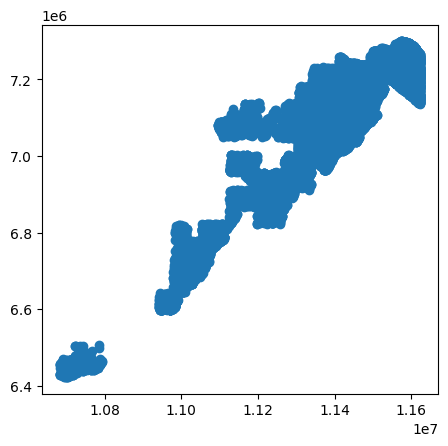

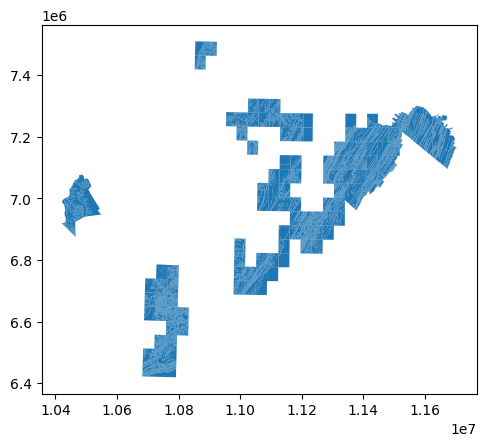

In [5]:
# master_dip_gdf.plot()
# master_geol_gdf.plot()

In [9]:
# Made a table for ppt.
names=[]
count=[]
for df in kp_strat_fin:
    names.append(df.wshed.values[0])
    count.append(len(df))
dic = pd.DataFrame(data=[names, count]).T
dic.columns = ['Watershed Name', 'Knickpoints with dip and geol data']
display(dic)

,Watershed Name,Knickpoints with dip and geol data
0,Savage_River,1
1,Stony_River-North_Branch_Potomac_River,2
2,Trading_Run-North_Branch_Potomac_River,1
3,Patterson_Creek,2
4,New_Creek-North_Branch_Potomac_River,3
5,Sleepy_Creek,53
6,Back_Creek,22
7,North_Fork_South_Branch_Potomac_River,13
8,Upper_South_Branch_Potomac_River,23
9,South_Fork_South_Branch_Potomac_River,31
